In [1]:
# Auto Reload
%load_ext autoreload
%autoreload 2

In [2]:
# Import Modules
import csv
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import json
from pprint import pprint
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from math import log
import re
import os
from gensim import corpora
from gensim.models.doc2vec import TaggedDocument
from gensim.models.doc2vec import Doc2Vec
from wordcloud import WordCloud

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA

from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis


# NLTK Modules
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('tagsets')
from nltk import sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import chunk
from nltk.util import ngrams

# Import Custom Modules
from src.data_cleaner import *
from src.dummy_words import *

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wesle\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wesle\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wesle\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\wesle\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [3]:
# Import Data
# clean_df = pd.read_pickle('data/clean_data.pkl')
clean_df = pd.read_pickle('data/all_clean_data.pkl')
# Rid Period from clean text
clean_df['clean_text'] = clean_df['clean_text'].apply(lambda x: "".join(x.split(".")))
# clean_df['clean_text'][0]

In [4]:
# See Current Features
# clean_df.columns
clean_df.head(2)

,song,artist,featured,rank,year,lyrics,lyrics_state,song_id,lyrics_owner_id,primary_artist_url,clean_text,sentences,tokens,tokens_stop,token_set
0,Thrift Shop,Macklemore & Ryan Lewis,NaN,1,2013,"[hey macklemore can we go thrift shopping, wha...",True,86538,3928,https://genius.com/artists/Macklemore-and-ryan...,hey macklemore can we go thrift shopping what ...,[hey macklemore can we go thrift shopping what...,"[hey, macklemore, can, we, go, thrift, shoppin...","[hey, macklemore, go, thrift, shopping, bada, ...","[da, ask, jammies, what, lookin, wolf, coppin,..."
1,Can't Hold Us,Macklemore & Ryan Lewis,NaN,2,2013,"[hey hey hey, good to see you, come on dude le...",True,57234,37383,https://genius.com/artists/Macklemore-and-ryan...,hey hey hey good to see you come on dude lets ...,[hey hey hey good to see you come on dude lets...,"[hey, hey, hey, good, to, see, you, come, on, ...","[hey, hey, hey, good, see, come, dude, lets, g...","[pounds, gone, humble, humility, what, city, g..."


# Text Mining Algorithms

### Vectorizing: Term Frequency-Inverse Document Frequency (TF-IDF)

> #### Getting TERM FREQUENCY
The number of times a term occurs in a specific document: 

$tf(term,document) = \frac{\# \ of \ times \ a \ term \ appears \ in \ a \ document}{\#\ of\ terms\ in\ the\ document|}$

In [5]:
# Add Features to DataFrame of Term Occurences
clean_df['term_occurences'] = clean_df['tokens'].apply(lambda x: Counter(x))
# clean_df['term_occurences'][0]

Deciding to use the tokens where the stop-words were NOT filtered out

In [6]:
# Add Features to DataFrame of Term Frequency
clean_df['term_frequency'] = [{k: (v / float(len(clean_df['tokens'].iloc[i])))
                       for k, v in clean_df['term_occurences'].iloc[i].items()} for i in range(len(clean_df['term_occurences']))]
# clean_df['term_frequency'][0]

> #### Getting DOCUMENT FREQUENCY

$df(term,corpus) = \frac{ \# \ of \ documents \ that \ contain \ a \ term}{ \# \ of \ documents \ in \ the \ corpus}$


In [7]:
# Add Features to DataFrame of Doc Occurences
doc_occ = Counter([word for bow in clean_df['tokens'] for word in set(bow)])
# doc_occ

In [8]:
# Add Features to DataFrame of Term Frequency
doc_freq =  {k: (v / float(len(clean_df['tokens'])))
            for k, v in doc_occ.items()}
# doc_freq

> #### TFIDF vector

$df(term,corpus) = \frac{ \# \ of \ documents \ that \ contain \ a \ term}{ \# \ of \ documents \ in \ the \ corpus}$

The inverse document frequency is defined in terms of the document frequency as

$idf(term,corpus) = \log{\frac{1}{df(term,corpus)}}$.

TF-IDF is an acronym for the product of two parts: the term frequency tf and what is called the inverse document frequency idf. The term frequency is just the counts in a term frequency vector. 

tf-idf $ = tf(term,document) * idf(term,corpus)$

In [9]:
tf_vectorizer = TfidfVectorizer()
vec = tf_vectorizer.fit_transform(clean_df['clean_text'])
vector_df_tf = pd.DataFrame(vec.toarray().transpose(),
                         index=tf_vectorizer.get_feature_names())
vector_df_tf

,0,1,2,3,4,5,6,7,8,9,...,340,341,342,343,344,345,346,347,348,349
00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zoua,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zow,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zucker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zuehlsdofrff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Testing Count Vectorizer

In [10]:
count_vec = CountVectorizer()
vec = count_vec.fit_transform(clean_df['clean_text'])
vector_df_cnt = pd.DataFrame(vec.toarray().transpose(),
                         index=count_vec.get_feature_names())
vector_df_cnt

,0,1,2,3,4,5,6,7,8,9,...,340,341,342,343,344,345,346,347,348,349
00000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zoua,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zow,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zucker,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zuehlsdofrff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# TOPIC MODELING

In [11]:
# Create Corpus
corpus = clean_df['clean_text'].tolist()
tokens = [word_tokenize(doc) for doc in corpus]
tokens_stop = clean_df['tokens_stop'].tolist() 


In [13]:
# Create Yearly Corpus
grouped = clean_df.groupby('year')

# group_2019 = clean_df.iloc[grouped.groups[2019]].copy()
# group_2018 = clean_df.iloc[grouped.groups[2018]].copy()
# group_2017 = clean_df.iloc[grouped.groups[2017]].copy()
# group_2016 = clean_df.iloc[grouped.groups[2016]].copy()
# group_2015 = clean_df.iloc[grouped.groups[2015]].copy()
# group_list = [group_2015, group_2016, group_2017, group_2018, group_2019]
group_list = [clean_df.iloc[grouped.groups[year]].copy() for year in range(2013, 2020)]

In [14]:
corpus[0][:100], tokens[0][:5], tokens_stop[0][:5]

('hey macklemore can we go thrift shopping what what what what what what what what what what what what',
 ['hey', 'macklemore', 'can', 'we', 'go'],
 ['hey', 'macklemore', 'go', 'thrift', 'shopping'])

## Looking at words by Year

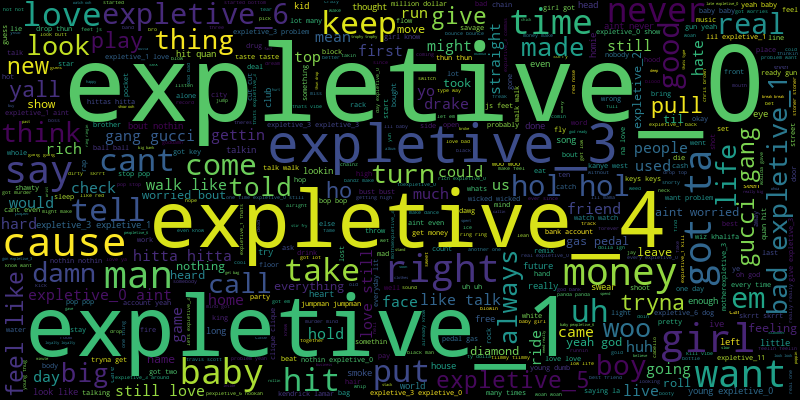

In [15]:
stops = ['im', 'thats', 'ya', 'though', 'yeah']
custom_stop = ['yeah', 'like', 'got', '2018', 'know', 'get', 'aint', 'ayy', 'go', 'na', 'back', 'one', 'gon', 'make', 'wan', 'thats', 'need', 'oh', 'see', 'feat', 'ooh', 'said', 'way', "2017", "la", 'lets', 'ft', 'let', 'hey', 'ima', 'uoeno', 'oohoohoohooh', 'ah', 'js', 'pare'] + stops
# Join the different processed titles together
long_string = ','.join([",".join(tokens) for tokens in tokens_stop])

# Create a WordCloud object
wordcloud = WordCloud(background_color="black", max_words=500, contour_width=3,  width=800, height=400, stopwords=custom_stop)

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

## Plot Most Common Words from CounterVectorizer

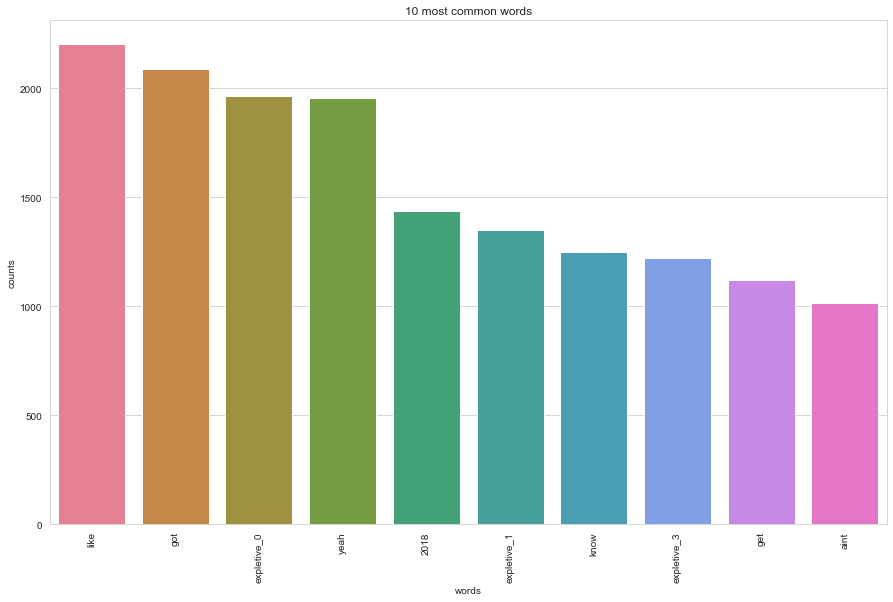

In [16]:
count_vec = CountVectorizer()
vec = count_vec.fit_transform([" ".join(set_) for set_ in clean_df['tokens_stop']])
vector_df_cnt = pd.DataFrame(vec.toarray().transpose(),
                         index=count_vec.get_feature_names())

# Visualise the 10 most common words
plot_10_most_common_words(vec, count_vec)

### Plot again after removing custom stop words (yeah, like, got, 2018, know, get, aint)

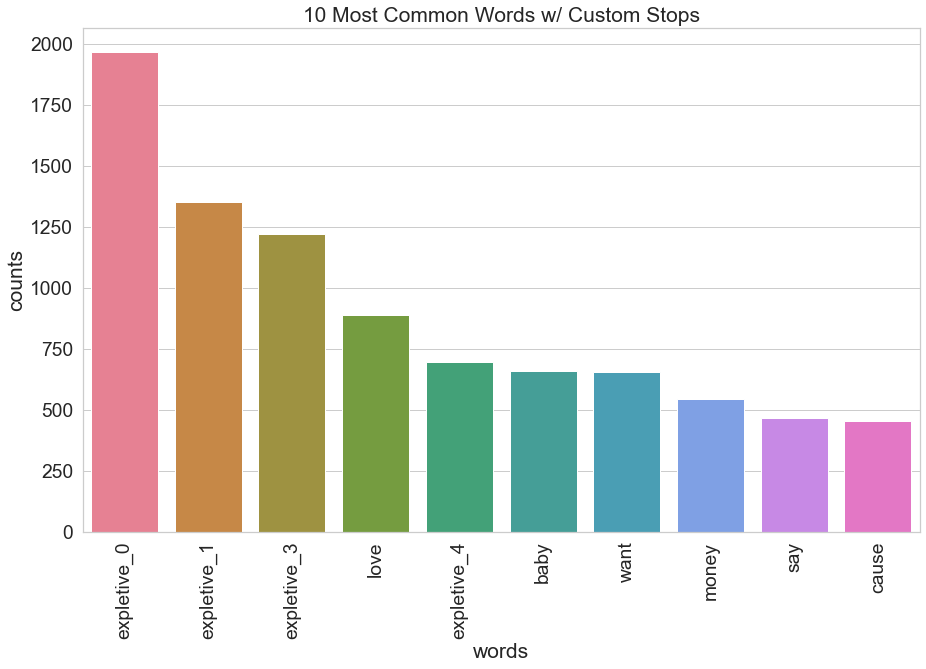

In [17]:
count_vec = CountVectorizer()
vec = count_vec.fit_transform([" ".join([x for x in set_ if x not in custom_stop]) for set_ in clean_df['tokens_stop']])
vector_df_cnt = pd.DataFrame(vec.toarray().transpose(),
                         index=count_vec.get_feature_names())

# Visualise the 10 most common words
plot_10_most_common_words(vec, count_vec, '10 Most Common Words w/ Custom Stops')

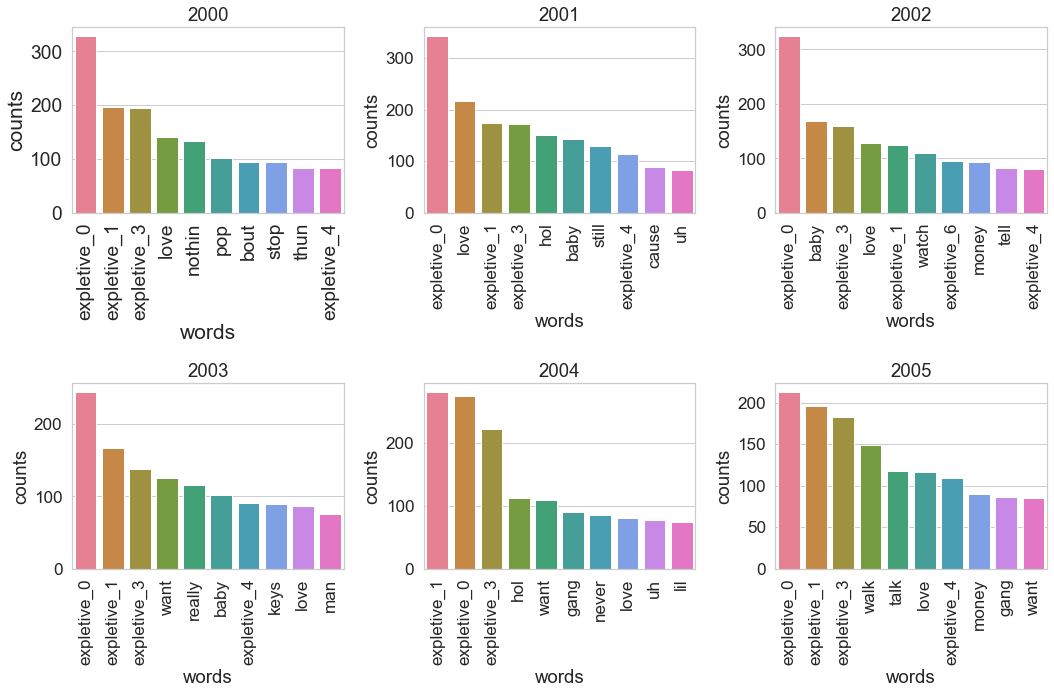

In [18]:
fig = plt.figure(figsize=(15, 10))

for year, group, i in zip(range(2000, 2006), group_list[:6], range(1,7)):
    count_vec = CountVectorizer()
    vec = count_vec.fit_transform([" ".join([x for x in set_ if x not in custom_stop]) for set_ in group['tokens_stop']])
    vector_df_cnt = pd.DataFrame(vec.toarray().transpose(),
                             index=count_vec.get_feature_names())
    words = count_vec.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in vec:
        total_counts+=t.toarray()[0]

    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 

    fig.add_subplot(2, 3, i)
    sns.set_context("notebook", font_scale=1.55, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.title(year)
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')

fig.tight_layout()

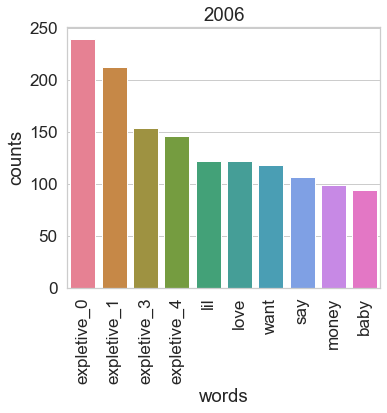

In [19]:
fig = plt.figure(figsize=(15, 10))

for year, group, i in zip(range(2006, 2012), group_list[6:12], range(1,7)):
    count_vec = CountVectorizer()
    vec = count_vec.fit_transform([" ".join([x for x in set_ if x not in custom_stop]) for set_ in group['tokens_stop']])
    vector_df_cnt = pd.DataFrame(vec.toarray().transpose(),
                             index=count_vec.get_feature_names())
    words = count_vec.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in vec:
        total_counts+=t.toarray()[0]

    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 

    fig.add_subplot(2, 3, i)
    sns.set_context("notebook", font_scale=1.55, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.title(year)
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')

fig.tight_layout()

In [20]:
fig = plt.figure(figsize=(15, 10))

for year, group, i in zip(range(2012, 2018), group_list[12:18], range(1,7)):
    count_vec = CountVectorizer()
    vec = count_vec.fit_transform([" ".join([x for x in set_ if x not in custom_stop]) for set_ in group['tokens_stop']])
    vector_df_cnt = pd.DataFrame(vec.toarray().transpose(),
                             index=count_vec.get_feature_names())
    words = count_vec.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in vec:
        total_counts+=t.toarray()[0]

    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 

    fig.add_subplot(2, 3, i)
    sns.set_context("notebook", font_scale=1.55, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.title(year)
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')

fig.tight_layout()

<Figure size 1080x720 with 0 Axes>

In [21]:
fig = plt.figure(figsize=(15, 10))

for year, group, i in zip(range(2018, 2020), group_list[18:], range(1,7)):
    count_vec = CountVectorizer()
    vec = count_vec.fit_transform([" ".join([x for x in set_ if x not in custom_stop]) for set_ in group['tokens_stop']])
    vector_df_cnt = pd.DataFrame(vec.toarray().transpose(),
                             index=count_vec.get_feature_names())
    words = count_vec.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in vec:
        total_counts+=t.toarray()[0]

    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 

    fig.add_subplot(2, 3, i)
    sns.set_context("notebook", font_scale=1.55, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.title(year)
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')

fig.tight_layout()

<Figure size 1080x720 with 0 Axes>

## LDA Latent Dirichlet Allocation

### 2013-2019 Topics via LDA

In [22]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform([" ".join([x for x in set_ if x not in custom_stop]) for set_ in clean_df['tokens_stop']])

# Tweak the two parameters below (use int values below 15)
number_topics = 7
number_words = 15

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=7, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [23]:
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
expletive_0 love uh expletive_1 woo expletive_6 baby man money expletive_3 skrrt drop thun cardi bad

Topic #1:
expletive_3 expletive_1 expletive_0 expletive_4 baby love right cause time say god real tell want better

Topic #2:
gang gucci watch lil wicked drake cut love west kanye bust expletive_3 bop expletive_1 young

Topic #3:
hitta hittas love lil 2016 money black expletive_3 young ring saying rake world rich mask

Topic #4:
expletive_0 expletive_1 walk expletive_3 want love nothin talk money bout feel ball bank taste young

Topic #5:
expletive_0 expletive_3 expletive_4 hol really expletive_1 look want man em say cause money keys feel

Topic #6:
expletive_0 expletive_1 expletive_3 baby want expletive_4 hit love pop right expletive_2 ta girl cause money


### Use pyLDAvis to see results

In [24]:
%%time

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))

LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

Wall time: 7min 58s


c:\users\wesle\appdata\local\programs\python\python37-32\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [25]:
# Write to File
pyLDAvis.save_html(LDAvis_prepared, 'docs/lda.html')

In [26]:
# LDAvis_prepared

# LDA Revised with removing ALL Expletives

In [32]:
# Custom Function to remove expletives
def match_expletive(item:str):
    """Replaces expletive with empty string"""
    item = re.sub(r'(expleti*)(.*?)\b', '', item)
    return item
# New Stops
stop_words = set(stopwords.words('english'))
stops = [
'im', 'thats', 'ya', 'though', 'yeah', 'like', 'got', '2018', 'know', 'get', 'aint', 
'ayy', 'go', 'na', 'back', 'one', 'gon', 'make', 
'wan', 'thats', 'need', 'oh', 'see', 'feat', 'ooh', 'said', 'way', "2017", 
"la", 'lets', 'ft', 'let', 'hey', 'ima', 'uoeno', 'oohoohoohooh', 'ah', 'js', 
'pare', 'yuh', 'what', 'bada', 'doo', 'da', 'that', 'ill', 'alllanggahmollah'] + re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", " ".join(stop_words)).split()



clean_stop_tokens = clean_df['lyrics'].apply(lambda x: " ".join([i.strip() for i in x if i]))
clean_stop_tokens = list(map(lambda x: (match_dummies(x, False).split()), clean_stop_tokens))

In [33]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform([" ".join([x for x in set_ if x not in stops]) for set_ in clean_stop_tokens])

# Tweak the two parameters below (use int values below 15)
number_topics = 15
number_words = 20

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=15, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [34]:
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
baby really dance goin say cause started right man think timber better real look beat bag crazy round bandz lil

Topic #1:
walk talk hit look quan type clique tell woo want hot girl little say cause man lil butt life low

Topic #2:
want bank problem gang gucci money god love lot account huh say high life ready uh bad wild red big

Topic #3:
watch gas pedal ball lit different bop everyday stoner rake nae tell bad feel real clout money right worries whip

Topic #4:
love baby em want dog money man gonna bust cause mediocre ho wanna right thou 21 boy yo hit real

Topic #5:
love better 2016 say lil gave money rockstar cause woulda time big ive brown think aap young 2015 remix good

Topic #6:
love want man saying tell cardi gotta girl cause feelin really city uh good look body bust money em loyalty

Topic #7:
feet tap wishin million saucin swaggin dollar ballin watch shot touch style gangnam sexy lady high club spendin new things

Topic #8:
love keys young dr

In [35]:
%%time

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))

LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

Wall time: 8min 46s


c:\users\wesle\appdata\local\programs\python\python37-32\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [36]:
# Write to File
pyLDAvis.save_html(LDAvis_prepared, 'docs/post_lda.html')

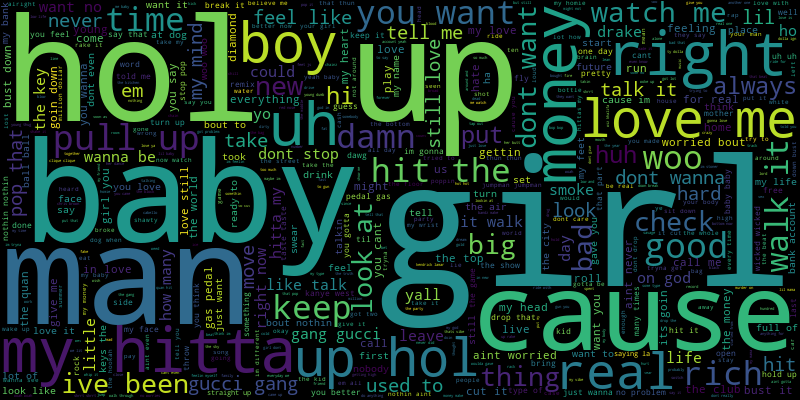

In [37]:
# Join the different processed titles together
long_string = ','.join([",".join(x) for x in clean_stop_tokens])

# Create a WordCloud object
wordcloud = WordCloud(background_color="black", max_words=500, contour_width=3,  width=800, height=400, stopwords=stops)

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

# Word Cloud by Year

#### 2013

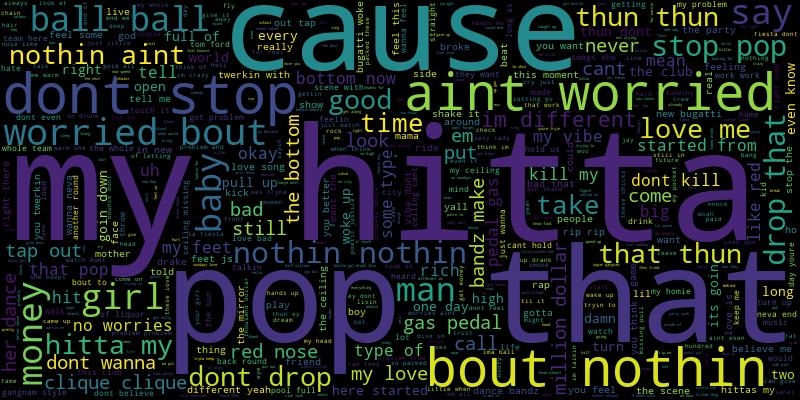

In [38]:
year = 2013
tokens = clean_df['lyrics'][clean_df['year'] == year].apply(lambda x: " ".join([i.strip() for i in x if i]))
tokens = list(map(lambda x: (match_dummies(x, False).split()), tokens))

# Join the different processed titles together
long_string = ','.join([",".join(x) for x in tokens])

# Create a WordCloud object
wordcloud = WordCloud(background_color="black", max_words=500, contour_width=3,  width=800, height=400, stopwords=stops)

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

#### 2015

In [ ]:
year = 2015
tokens = clean_df['lyrics'][clean_df['year'] == year].apply(lambda x: " ".join([i.strip() for i in x if i]))
tokens = list(map(lambda x: (match_dummies(x, False).split()), tokens))

# Join the different processed titles together
long_string = ','.join([",".join(x) for x in tokens])

# Create a WordCloud object
wordcloud = WordCloud(background_color="black", max_words=500, contour_width=3,  width=800, height=400, stopwords=stops)

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [ ]:
year = 2019
tokens = clean_df['lyrics'][clean_df['year'] == year].apply(lambda x: " ".join([i.strip() for i in x if i]))
tokens = list(map(lambda x: (match_dummies(x, False).split()), tokens))

# Join the different processed titles together
long_string = ','.join([",".join(x) for x in tokens])

# Create a WordCloud object
wordcloud = WordCloud(background_color="black", max_words=500, contour_width=3,  width=800, height=400, stopwords=stops)

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()